In [17]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from hentai import Utils, Hentai
from pathlib import Path

## Data Collection

We will be using the doujin dataset obtained from nhentai.

## Download dataset

In [ ]:
def get_random_hentais(n: int) -> list(Hentai):
    """
    Parameters
    ----------
    n
        Maximum number of images to randomly get.
    """

    return [Utils.get_random_hentai() for _ in range(0, n)]

hentais = get_random_hentais(10)

## Download images

In [ ]:
for hentai in hentais:
    path = Path(os.path.join("data", str(hentai.id)))
    doujin.download(path, progressbar=True)
path = Path(os.path.join("data", "metadata.json"))
Utils.export(hentais, path)

## Read dataset file

In [18]:
hentais = pd.read_json("data/metadata.json", orient='records')
hentais.head()

,id,title,scanlator,url,api,media_id,epos,num_favorites,tag,group,parody,character,language,artist,category,cover,thumbnail,image_urls,num_pages
0,320206,Kitsune to Ikenie.,,https://nhentai.net/g/320206,https://nhentai.net/api/gallery/320206,1681447,1594551471,1179,"[sole male, big breasts, collar, fox girl, kem...",[],[original],[],"[english, translated]",[hroz],[doujinshi],https://t.nhentai.net/galleries/1681447/cover.jpg,https://t.nhentai.net/galleries/1681447/thumb.jpg,[https://i.nhentai.net/galleries/1681447/1.jpg...,12
1,36424,Yogosareta Shoujo,,https://nhentai.net/g/36424,https://nhentai.net/api/gallery/36424,161750,1403988834,280,"[group, ryona, exhibitionism, defloration, min...",[],[],[],"[english, translated]",[kawady max],[manga],https://t.nhentai.net/galleries/161750/cover.jpg,https://t.nhentai.net/galleries/161750/thumb.jpg,"[https://i.nhentai.net/galleries/161750/1.jpg,...",23
2,205418,ore no ooo ni kisu o shina,,https://nhentai.net/g/205418,https://nhentai.net/api/gallery/205418,1104489,1503555607,30,"[anal, double anal, group, males only, muscle,...",[romanesque],[tiger and bunny],[ryan goldsmith],[japanese],[],[doujinshi],https://t.nhentai.net/galleries/1104489/cover.jpg,https://t.nhentai.net/galleries/1104489/thumb.jpg,[https://i.nhentai.net/galleries/1104489/1.jpg...,36
3,206822,Ochibure Charisma Cosplayer!,,https://nhentai.net/g/206822,https://nhentai.net/api/gallery/206822,1109009,1504435965,446,"[full color, group, ahegao, anal, double penet...",[rubi-sama wo agameru kai],[],[],"[chinese, translated]",[rubi-sama],[doujinshi],https://t.nhentai.net/galleries/1109009/cover.jpg,https://t.nhentai.net/galleries/1109009/thumb.jpg,[https://i.nhentai.net/galleries/1109009/1.jpg...,26
4,328167,Sakura-chan Kouin Manga,,https://nhentai.net/g/328167,https://nhentai.net/api/gallery/328167,1728654,1599638164,232,"[lolicon, schoolgirl uniform, dilf, blowjob]",[futotta obasan],[cardcaptor sakura],[sakura kinomoto],[japanese],[],[doujinshi],https://t.nhentai.net/galleries/1728654/cover.gif,https://t.nhentai.net/galleries/1728654/thumb.gif,[https://i.nhentai.net/galleries/1728654/1.gif...,99


## Data preparation

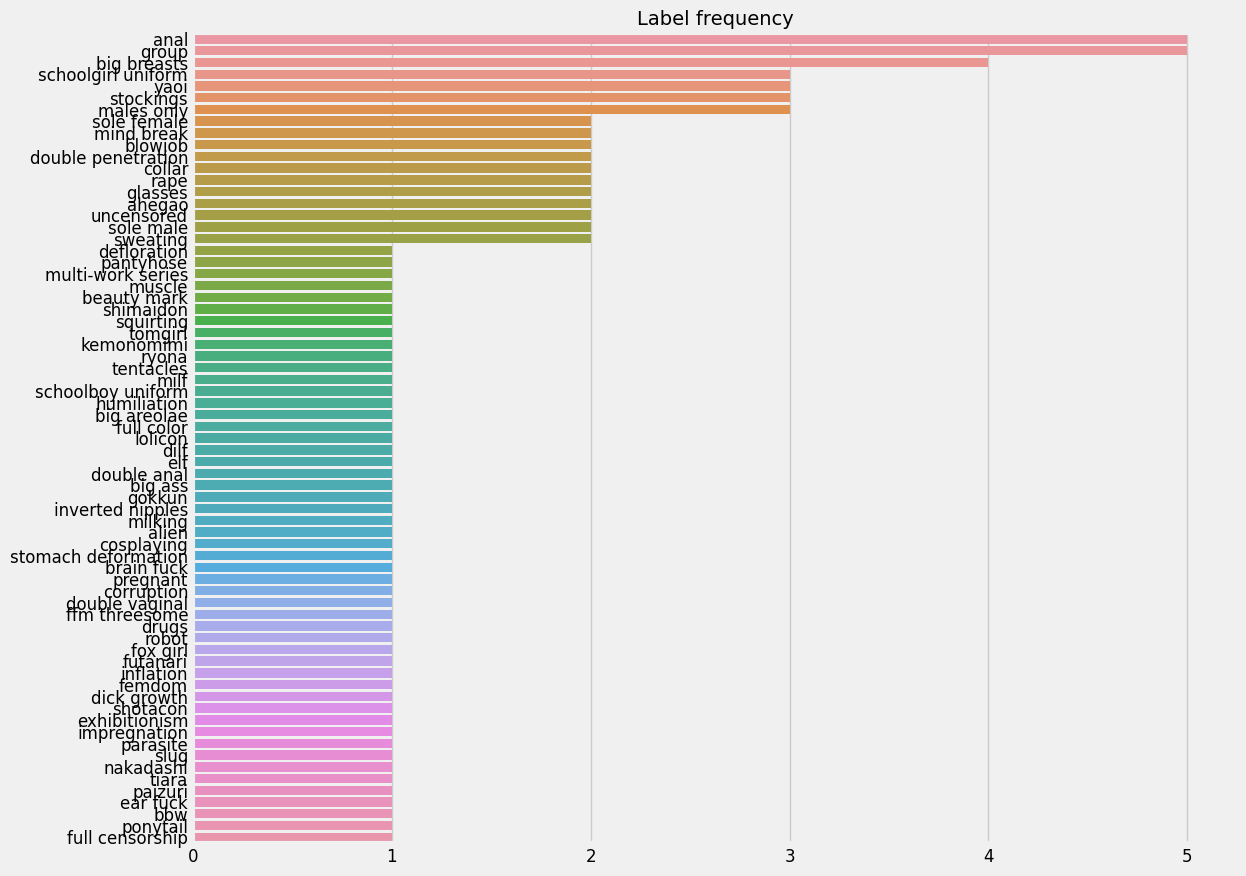

In [19]:
# Get label frequencies in descending order
label_freq = hentais['tag'].explode().value_counts().sort_values(ascending=False)

# Bar plot
style.use("fivethirtyeight")
plt.figure(figsize=(12,10))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Train / val split
Splitting the modeling data into training and validation is common in machine learning practice.
We will be allocating 80% of the images for training and 20% for validation.
Usually, we keep a final test set to communicate performance results but we will not really need it in this notebook.

In [20]:
X_train, X_val, y_train, y_val = train_test_split(hentais['id'], hentais['tag'], test_size=0.2, random_state=44)
print("Number of posters for training: ", len(X_train))
print("Number of posters for validation: ", len(X_val))

Number of posters for training:  8
Number of posters for validation:  2


We need to complete the full path to locate training and test images from the current working directory.

In [21]:
# TODO: for the moment we are only using the cover but we plan to experiment with a sequential model
X_train = [os.path.join('data/{}/1.jpg'.format(f)) for f in X_train]
X_val = [os.path.join('data/{}/1.jpg'.format(f)) for f in X_val]
pd.DataFrame(X_train, columns=['filenames']).head()

,filenames
0,data/274179/1.jpg
1,data/320206/1.jpg
2,data/317049/1.jpg
3,data/326894/1.jpg
4,data/144354/1.jpg


## Image examples

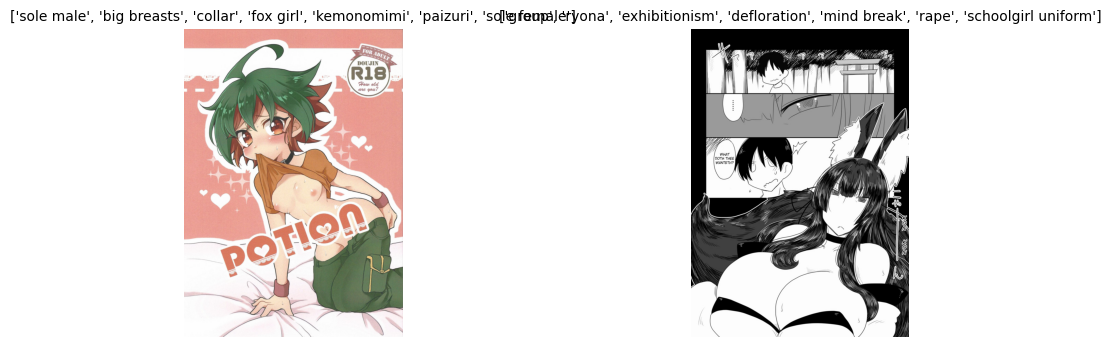

In [22]:
def plot_examples(nobs: int, ncols: int, nrows: int):
    """
    Parameters
    ----------
    nobs
        Maximum number of images to display.
    ncols
        Number of columns in display.
    nrows
        Number of rows in display.
    """

    style.use("default")
    plt.figure(figsize=(12, 4 * nrows))
    for i in range(nrows * ncols):
        ax = plt.subplot(nrows, ncols, i+1)
        plt.imshow(plt.imread(X_train[i]))
        plt.title(y_train[i], size=10)
        plt.axis('off')

plot_examples(nobs=10, ncols=2, nrows=1)

## Label encoding

The original targets are lists of strings that can be easily understood by humans.
But, if we want to build and train a neural network we need to create binary labels (multi-hot encoding).
This is critical for multi-label classification.

In order to binarize our labels, we will be using scikit-learn's MultiLabelBinarizer.

In [23]:
# Fit the multi-label binarizer on the training set
mlb = MultiLabelBinarizer()
mlb.fit(hentais['tag'])

# Loop over all labels and show them
N_LABELS = len(mlb.classes_)

pd.DataFrame({'labels': mlb.classes_})

,labels
0,ahegao
1,alien
2,anal
3,bbw
4,beauty mark
...,...
64,tentacles
65,tiara
66,tomgirl
67,uncensored


In [24]:
# transform the targets of the training and test sets
y_train_bin = mlb.transform(y_train)
y_val_bin = mlb.transform(y_val)

Let's check if everything worked correctly (We should obtain binary targets instead of list of strings).

In [25]:
# Print example of movie posters and their binary targets
pd.DataFrame(zip(X_train, y_train_bin), columns=["filename", "labels"]).head()

,filename,labels
0,data/274179/1.jpg,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
1,data/320206/1.jpg,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ..."
2,data/317049/1.jpg,"[1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, ..."
3,data/326894/1.jpg,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,data/144354/1.jpg,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
